In [30]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
library(Rcpp)


library(rpart)# Popular decision tree algorithm
#install.packages('rattle')
library(rattle)# Fancy tree plot
library(rpart.plot)# Enhanced tree plots
library(RColorBrewer)# Color selection for fancy tree plot
library(party) # Alternative decision tree algorithm
#install.packages('partykit')
library(partykit)# Convert rpart object to BinaryTree

#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')


#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)
#install.packages("scales")
library(scales)
#update.packages()
#install.packages("packagename")
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#install.packages("stats4")
#install.packages("splines")
library(stats4) #Load package stats
library(splines) #Load package splines
#To load package VGAM, need to load package stats4 and splines.
#install.packages("VGAM")
library(VGAM) #Load package VGAM


#install.packages("psych")
#install.packages("PerformanceAnalytics")
library(corrplot)
library(PerformanceAnalytics)
library(psych)

library(data.table)
library(writexl)



# FA (weighted) Classifcation

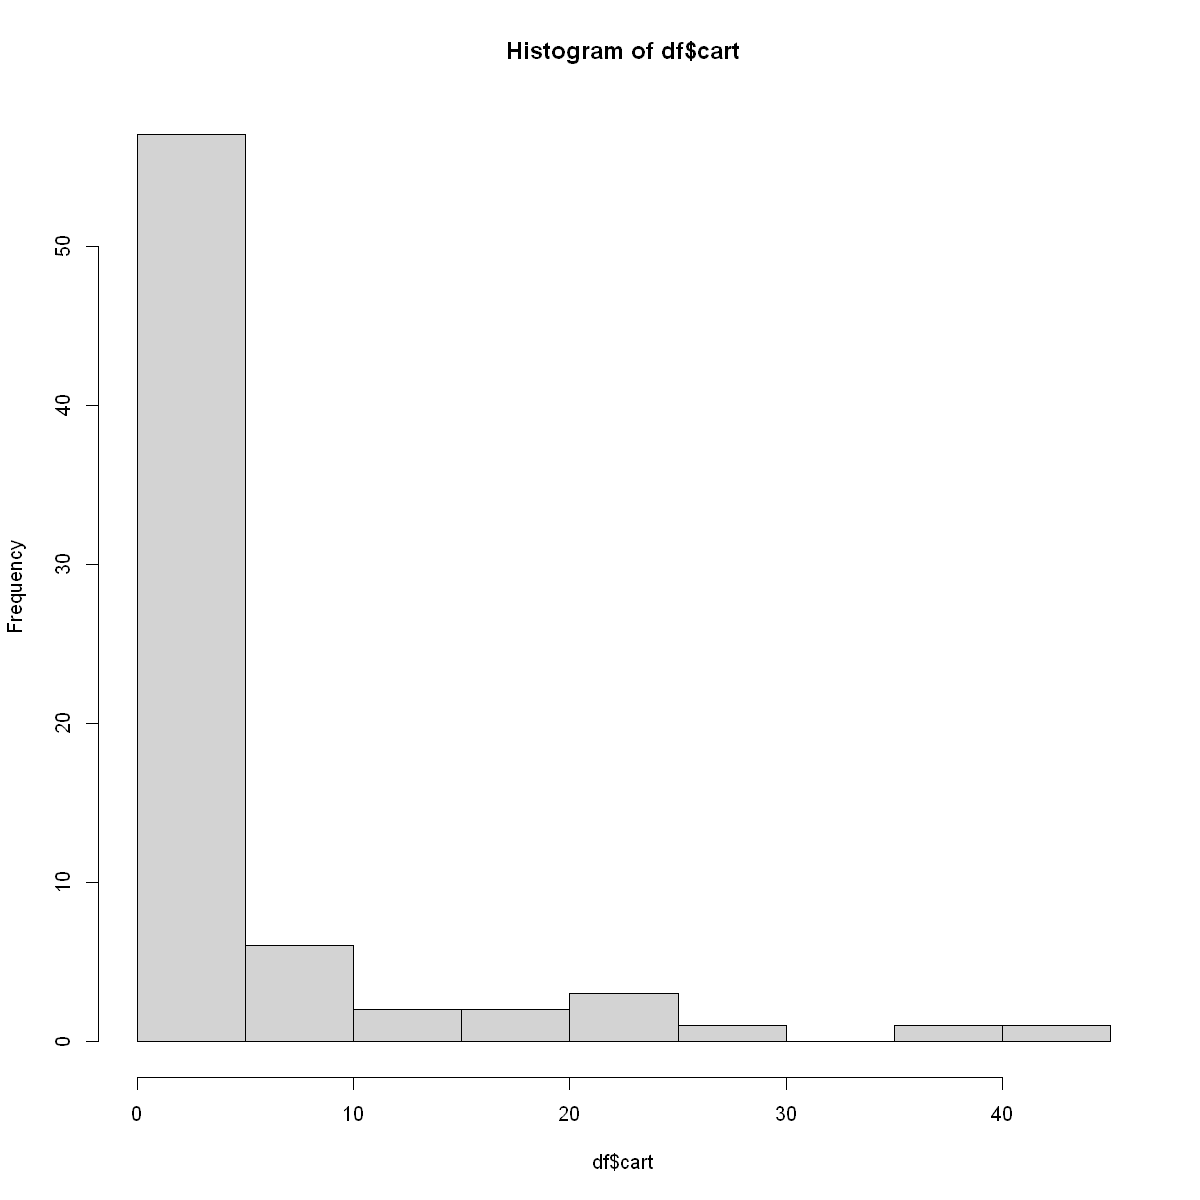

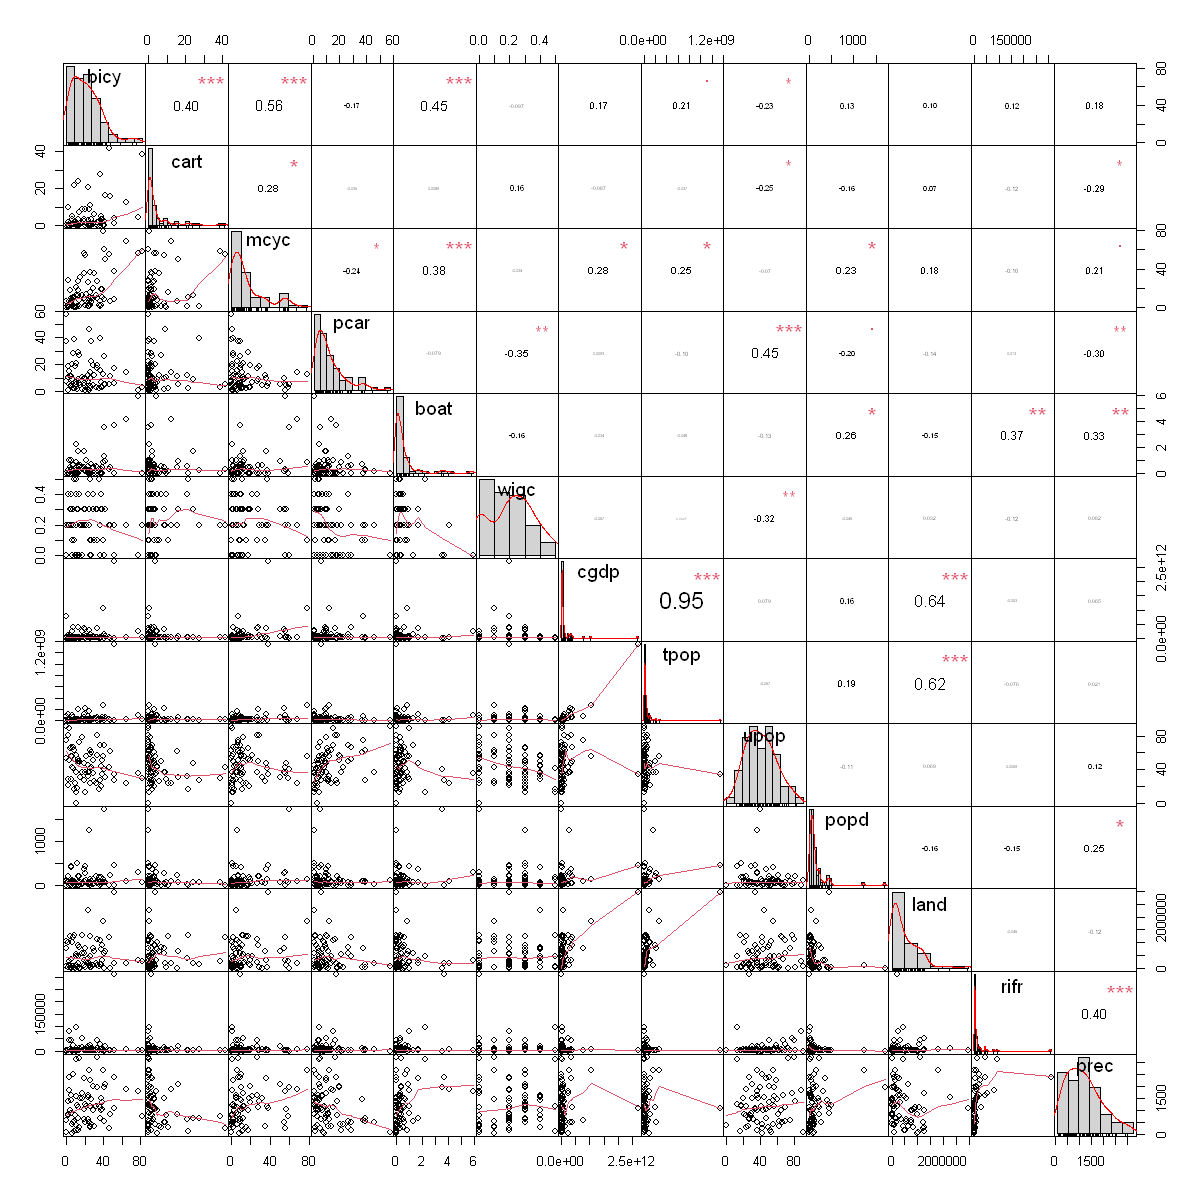

In [45]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-seven-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))

df <- df[, c(1:13, 17,21)]

#scaling the world bank data similar to DHS aggregation out of 100
df.wb <- df[,c(9:15)]
df.wb <- data.frame(lapply(df.wb, function(x) scale(x, center = FALSE, scale = max(x, na.rm = TRUE)/100)))
df.scale <- cbind(df, df.wb)
df.scale <- df.scale[,c(1:8,15:21)]


df.a <- df[, c(1:6,8)]
hist(df$cart)

explnatory <- df[,c(2:7, 9:15)]
chart.Correlation(explnatory, histogram=TRUE, pch=19 , tl.cex = .7 )
                           


In [46]:
# "Decentralized" , "Hybrid", "Centralized"
df <- df%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Decentralized",
    .$clusters=="2" ~ "Hybrid",
    .$clusters=="3" ~ "Centralized",
      ))

df.scale <- df.scale%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Decentralized",
    .$clusters=="2" ~ "Hybrid",
    .$clusters=="3" ~ "Centralized",
      ))


In [47]:
df$clusters <- as.factor(df$clusters)
df.scale$clusters <- as.factor(df.scale$clusters)
write_xlsx(df , '../../results/class.xlsx')
write_xlsx(df.scale , '../../results/class-scale.xlsx')
head(df)

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Decentralized,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Hybrid,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Decentralized,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Centralized,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Centralized,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Hybrid,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# Tree

In [48]:
# Make big tree
form <- as.formula(clusters ~ . - Country)
tree.fwa <- rpart(form,data=df,control=rpart.control(minsplit=4,cp=0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4 )
                 )

par(mar=c(1,1,1,1))

png(
  "cp.png",
  width     = 5,
  height    = 5,
  units     = "in",
  res       = 700,
  #pointsize = 6
)

#plot(tree.fwa)# Will make a mess of the plot
#text(tree.fwa)

plotcp(tree.fwa)

dev.off()

printcp(tree.fwa)

#summary(tree.fwa) 
#prp(tree.fwa)# Will plot the tree
#prp(tree.fwa,varlen=4)# Shorten variable names

png 
  2


Classification tree:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))

Variables actually used in tree construction:
[1] boat cgdp pcar popd prec

Root node error: 36/73 = 0.49315

n= 73 

        CP nsplit rel error  xerror    xstd
1 0.388889      0   1.00000 1.00000 0.11866
2 0.138889      1   0.61111 0.80556 0.11613
3 0.083333      2   0.47222 0.75000 0.11458
4 0.055556      3   0.38889 0.72222 0.11365
5 0.027778      4   0.33333 0.72222 0.11365
6 0.010000      6   0.27778 0.72222 0.11365


ERROR: Error in legend(x = x, y = y, legend = legend, col = 0, xpd = NA, bty = "n", : argument 8 matches multiple formal arguments


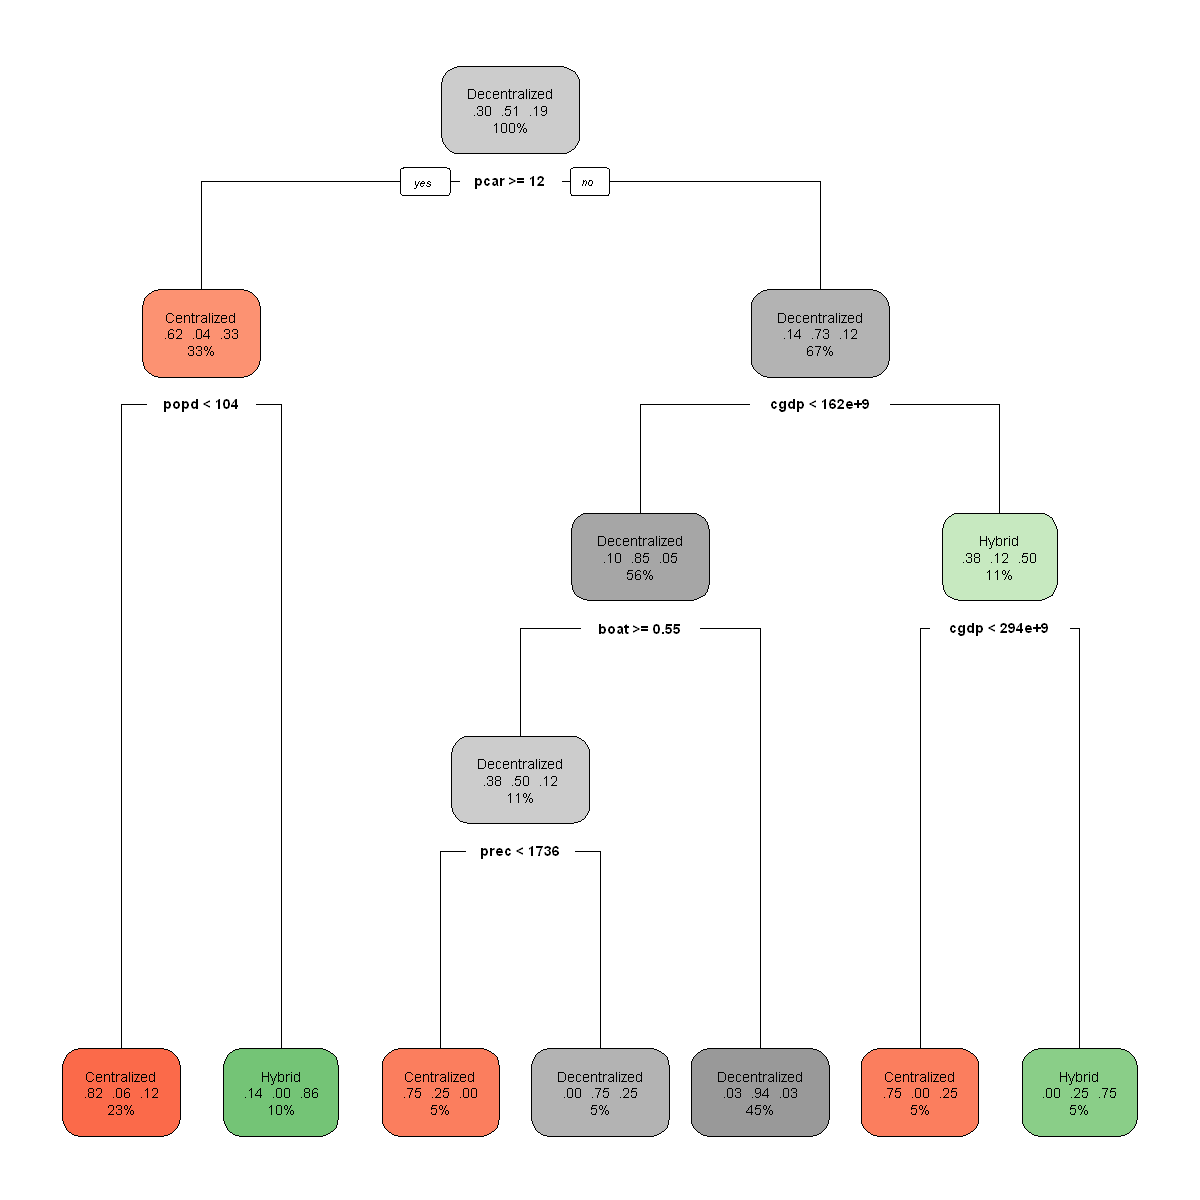

In [49]:
#size of the plot 
options(repr.plot.width=10, repr.plot.height=10)
par(mar = c(1,1,1,1))
par(cex=1)

#Interatively prune the tree
tree.pru <- prune(tree.fwa, cp=0.017) # interactively trim the tree
#prp(tree.pru) # display the new tree
rpart.plot(tree.pru)

In [50]:
par(mar=c(1,1,1,1))

png(
  "rpart.png",
  width     = 6,
  height    = 6,
  units     = "in",
  res       = 800,
  #pointsize = 6
)

fancyRpartPlot(tree.pru)


dev.off()

summary(tree.pru)

png 
  2

Call:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))
  n= 73 

          CP nsplit rel error    xerror      xstd
1 0.38888889      0 1.0000000 1.0000000 0.1186556
2 0.13888889      1 0.6111111 0.8055556 0.1161345
3 0.08333333      2 0.4722222 0.7500000 0.1145768
4 0.05555556      3 0.3888889 0.7222222 0.1136506
5 0.02777778      4 0.3333333 0.7222222 0.1136506
6 0.01000000      6 0.2777778 0.7222222 0.1136506

Variable importance
pcar cgdp popd boat prec 
  43   25   18    7    6 

Node number 1: 73 observations,    complexity param=0.3888889
  predicted class=Decentralized  expected loss=0.4931507  P(node) =1
    class counts:    22    37    14
   probabilities: 0.301 0.507 0.192 
  left son=2 (24 obs) right son=3 (49 obs)
  Primary splits:
      pcar < 12.4         to the right, improve=12.198510, (0 missing)
      wigc < 0.25         to the left,  improve= 6.923826, (0 missing)
      cgdp < 10

Warning message:
"ignoring snip=TRUE for png device"


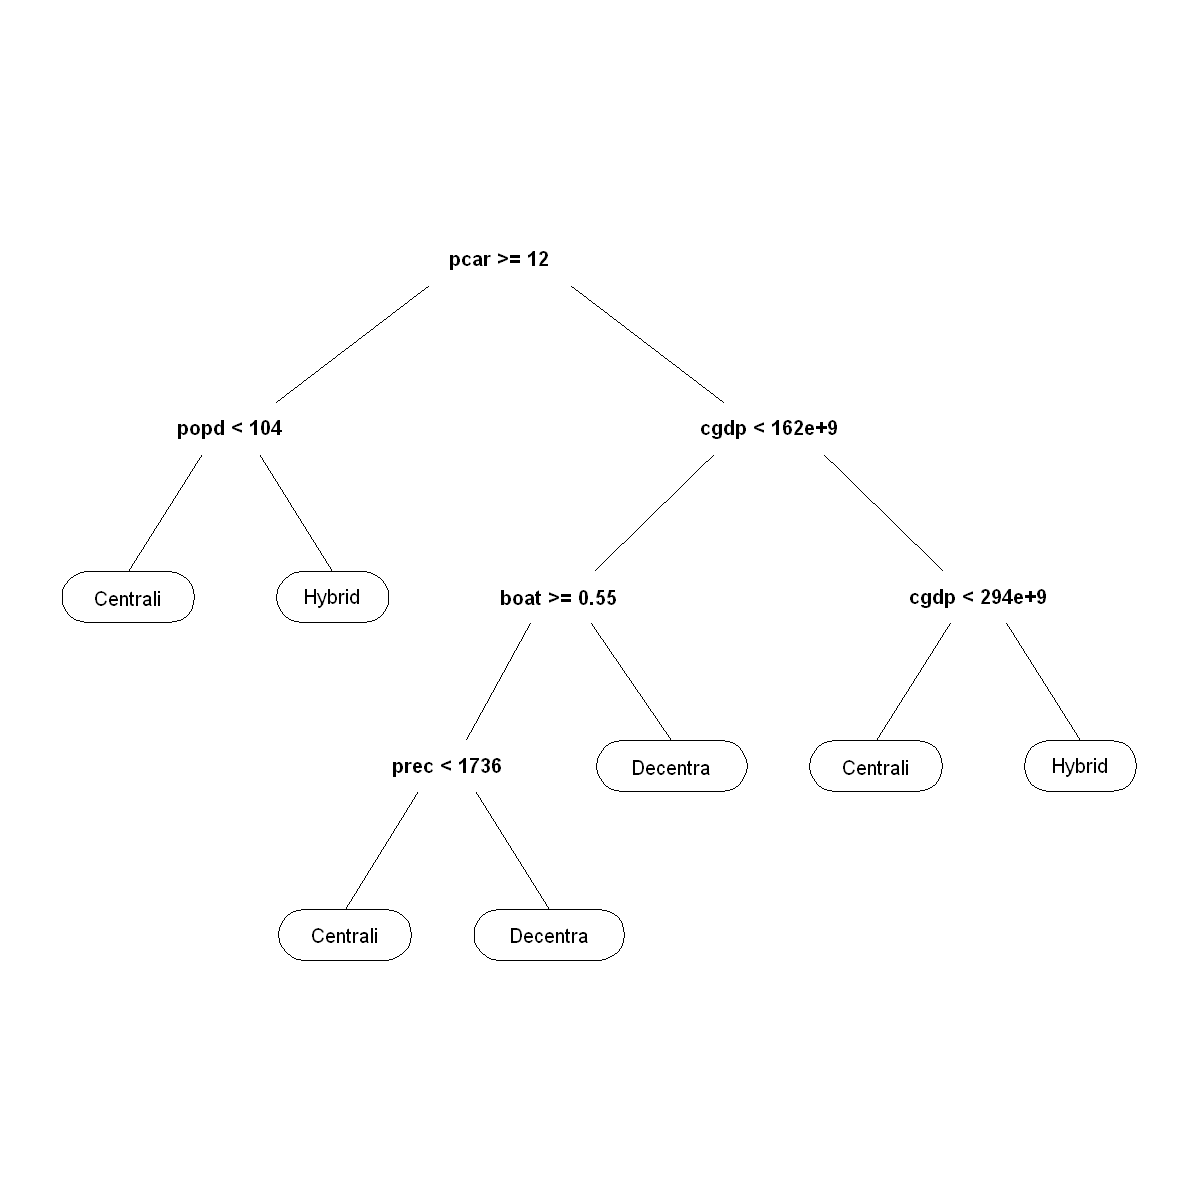

In [51]:
prp(tree.fwa, snip=TRUE)

http://www.milbo.org/rpart-plot/prp.pdf
http://www.di.fc.ul.pt/~jpn/r/tree/tree.html


Classification tree:
tree(formula = clusters ~ . - Country, data = df.scale)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

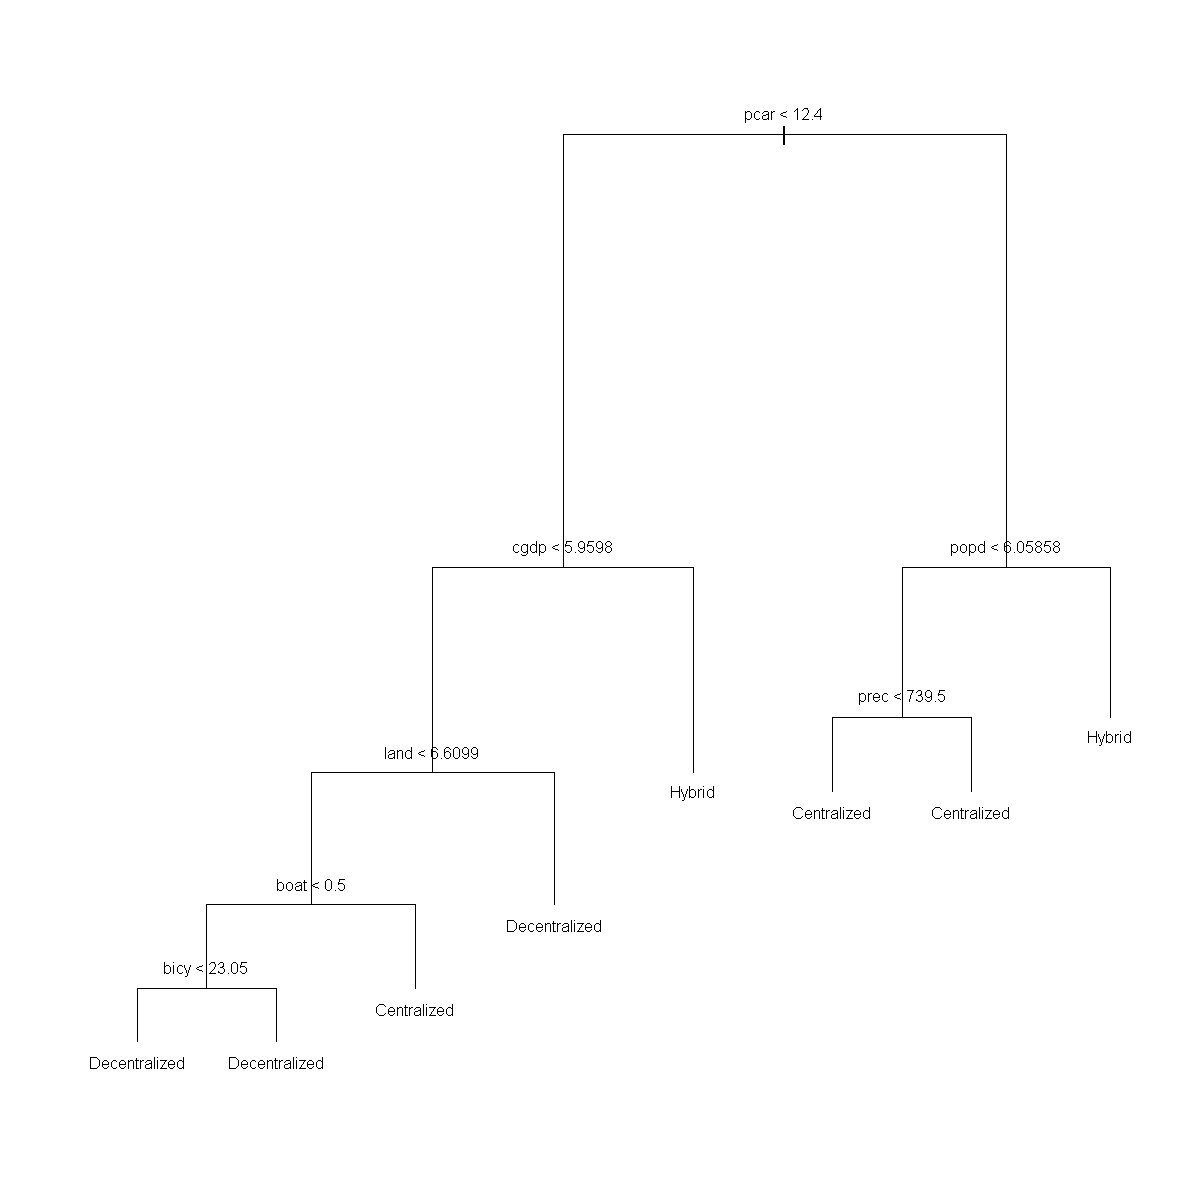

In [52]:
tree.wa = tree(clusters ~ . - Country  , data = df.scale)
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.8) 


Classification tree:
tree(formula = clusters ~ . - Country, data = df, mindev = 0.01)
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "bicy" "popd" "prec"
Number of terminal nodes:  8 
Residual mean deviance:  0.8264 = 53.72 / 65 
Misclassification error rate: 0.1644 = 12 / 73 

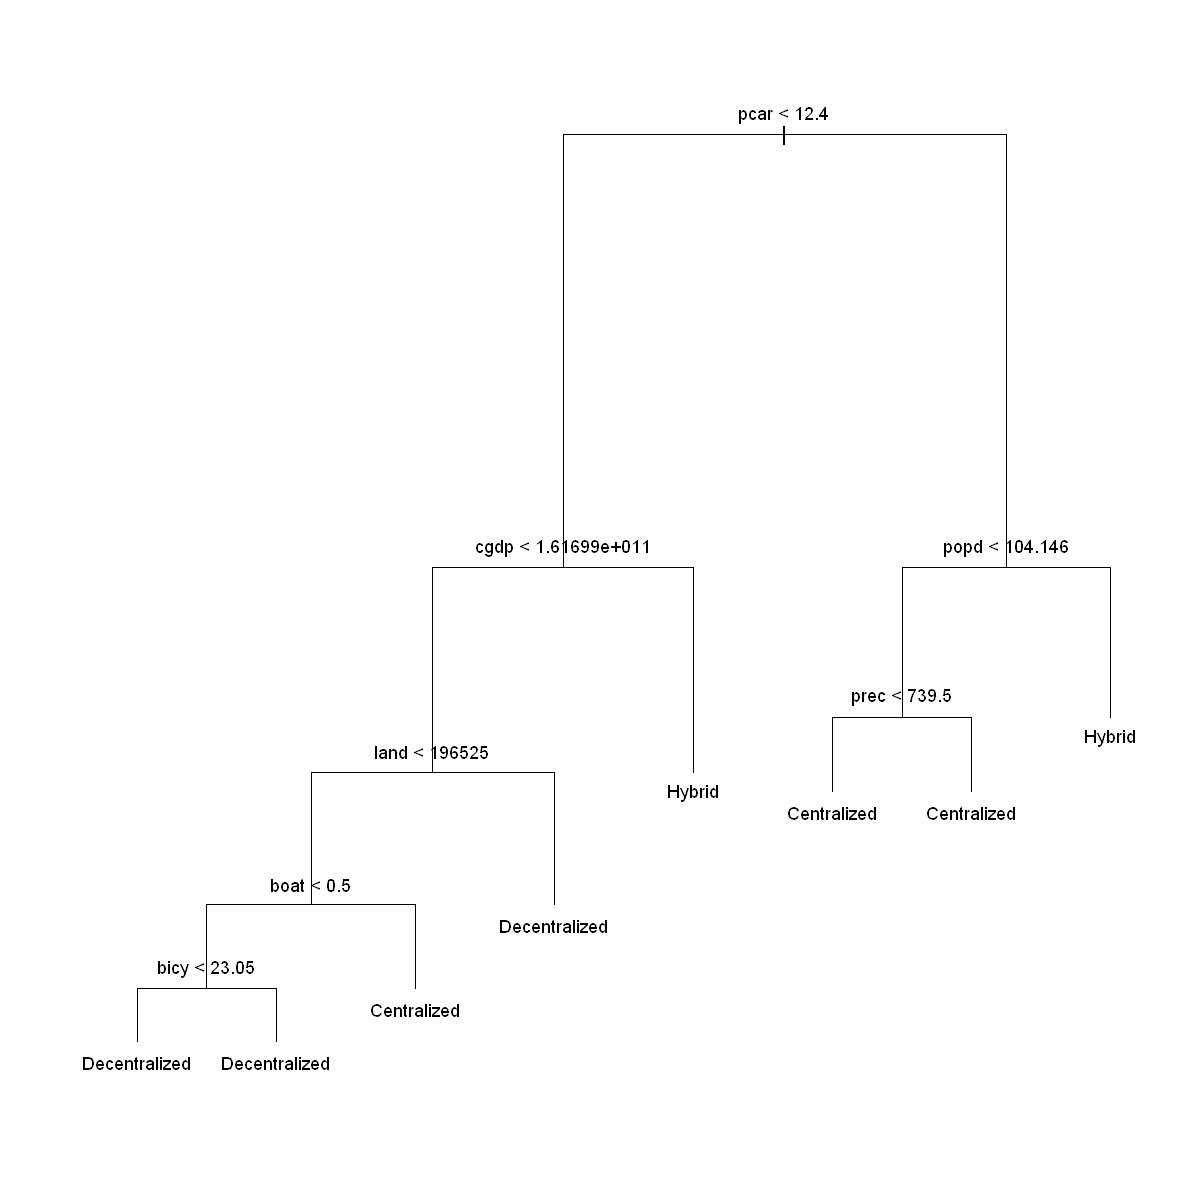

In [53]:
tree.wa = tree(clusters ~ . - Country  , data = df, mindev=0.01, )
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.90) 

# Distributional prediction
my.prediction <- predict(tree.wa) # gives the probability for each class
head(my.prediction)

# Point prediction
# Let's translate the probability output to categorical output
maxidx <- function(arr) {
    return(which(arr == max(arr)))
}
idx <- apply(my.prediction, c(1), maxidx)
prediction <- c("Worst Water Source", "Better Water Source", "Best Water Source")[idx]
table(prediction, df.scale$clusters)

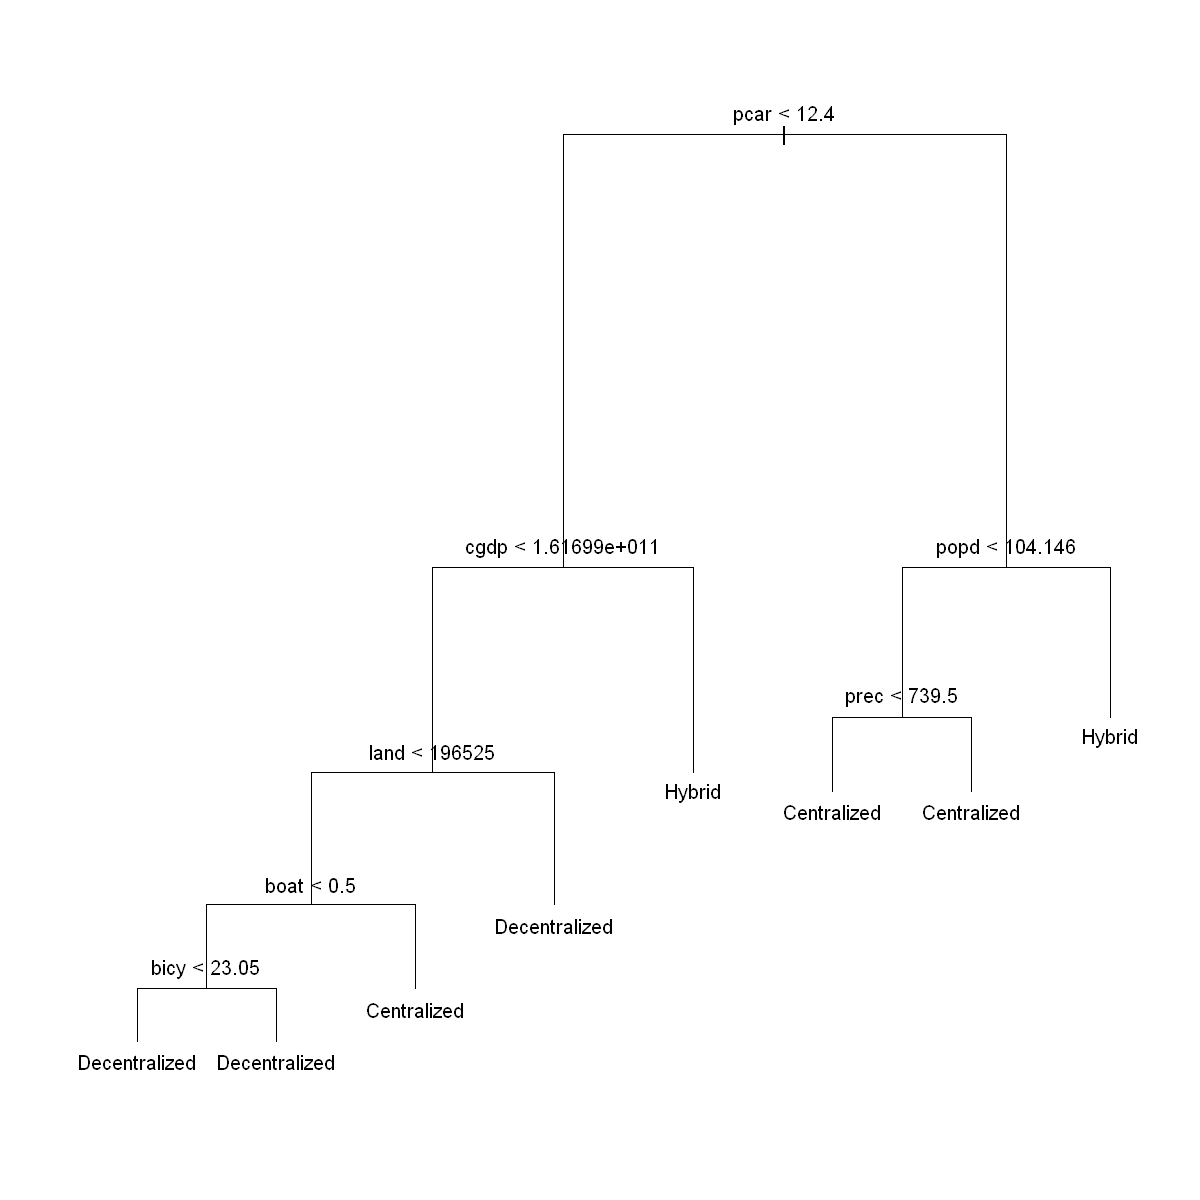

In [54]:
plot(tree.wa)
text(tree.wa)


Classification tree:
snip.tree(tree = tree.wa, nodes = c(16L, 6L))
Variables actually used in tree construction:
[1] "pcar" "cgdp" "land" "boat" "popd"
Number of terminal nodes:  6 
Residual mean deviance:  0.9617 = 64.43 / 67 
Misclassification error rate: 0.1644 = 12 / 73 

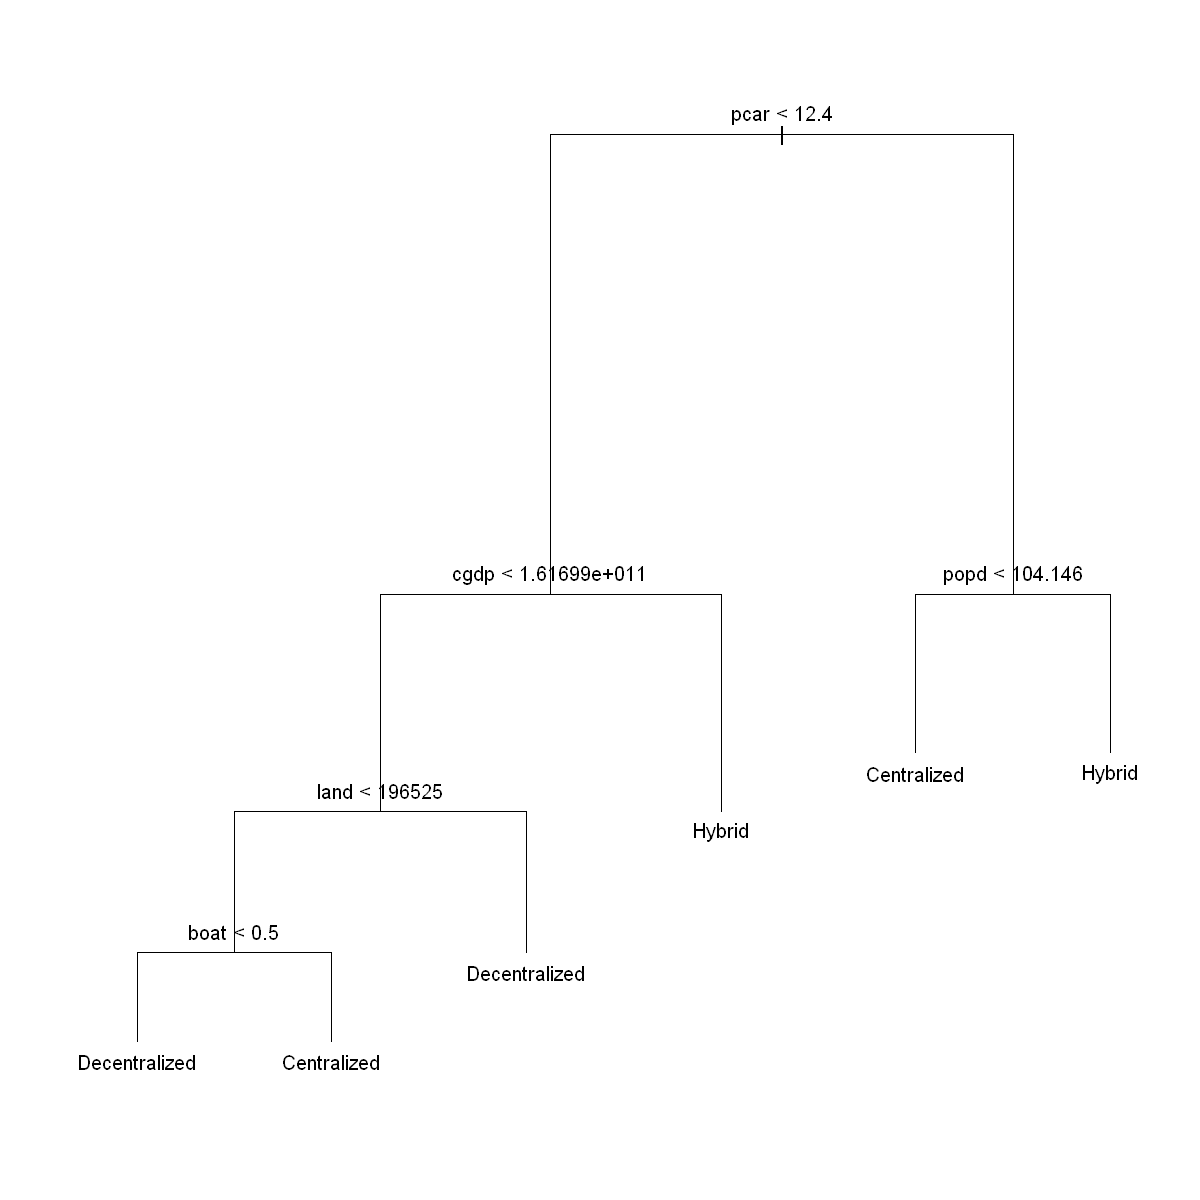

In [55]:
pru.wa <- prune.tree(tree.wa, best = 6 )
summary(pru.wa)
plot(pru.wa)
text(pru.wa, pretty = 0)


# Random Forest


Call:
 randomForest(formula = clusters ~ . - Country, data = df, ntree = 200,      mtry = 12) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 12

        OOB estimate of  error rate: 34.25%
Confusion matrix:
              Centralized Decentralized Hybrid class.error
Centralized            13             5      4   0.4090909
Decentralized           7            29      1   0.2162162
Hybrid                  5             3      6   0.5714286


                Length Class  Mode     
call              5    -none- call     
type              1    -none- character
predicted        73    factor numeric  
err.rate        800    -none- numeric  
confusion        12    -none- numeric  
votes           219    matrix numeric  
oob.times        73    -none- numeric  
classes           3    -none- character
importance       13    -none- numeric  
importanceSD      0    -none- NULL     
localImportance   0    -none- NULL     
proximity         0    -none- NULL     
ntree             1    -none- numeric  
mtry              1    -none- numeric  
forest           14    -none- list     
y                73    factor numeric  
test              0    -none- NULL     
inbag             0    -none- NULL     
terms             3    terms  call     

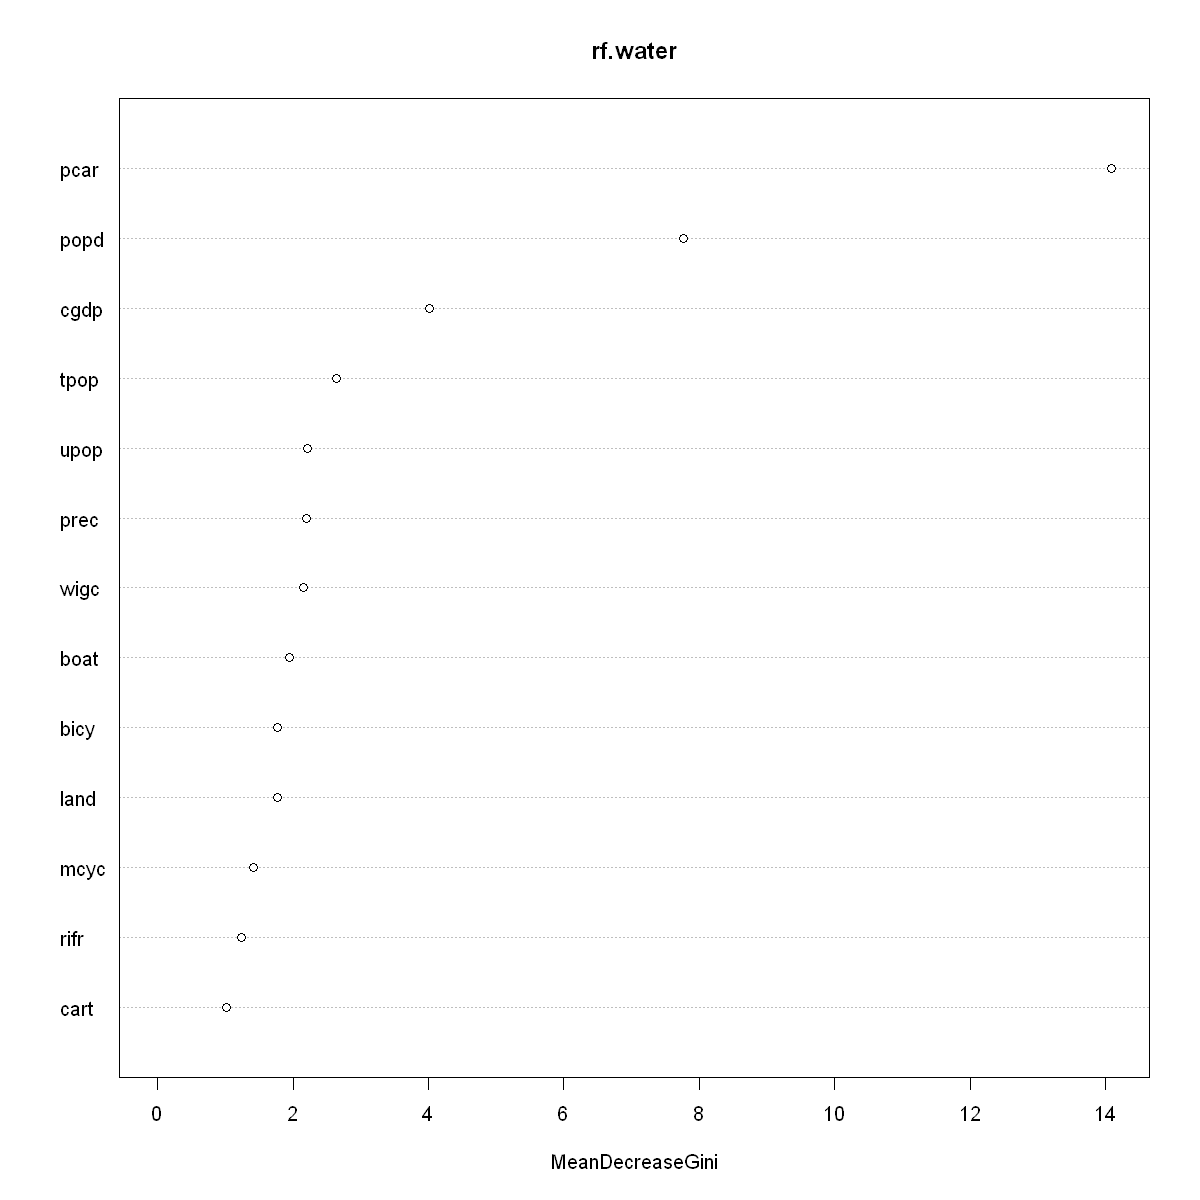

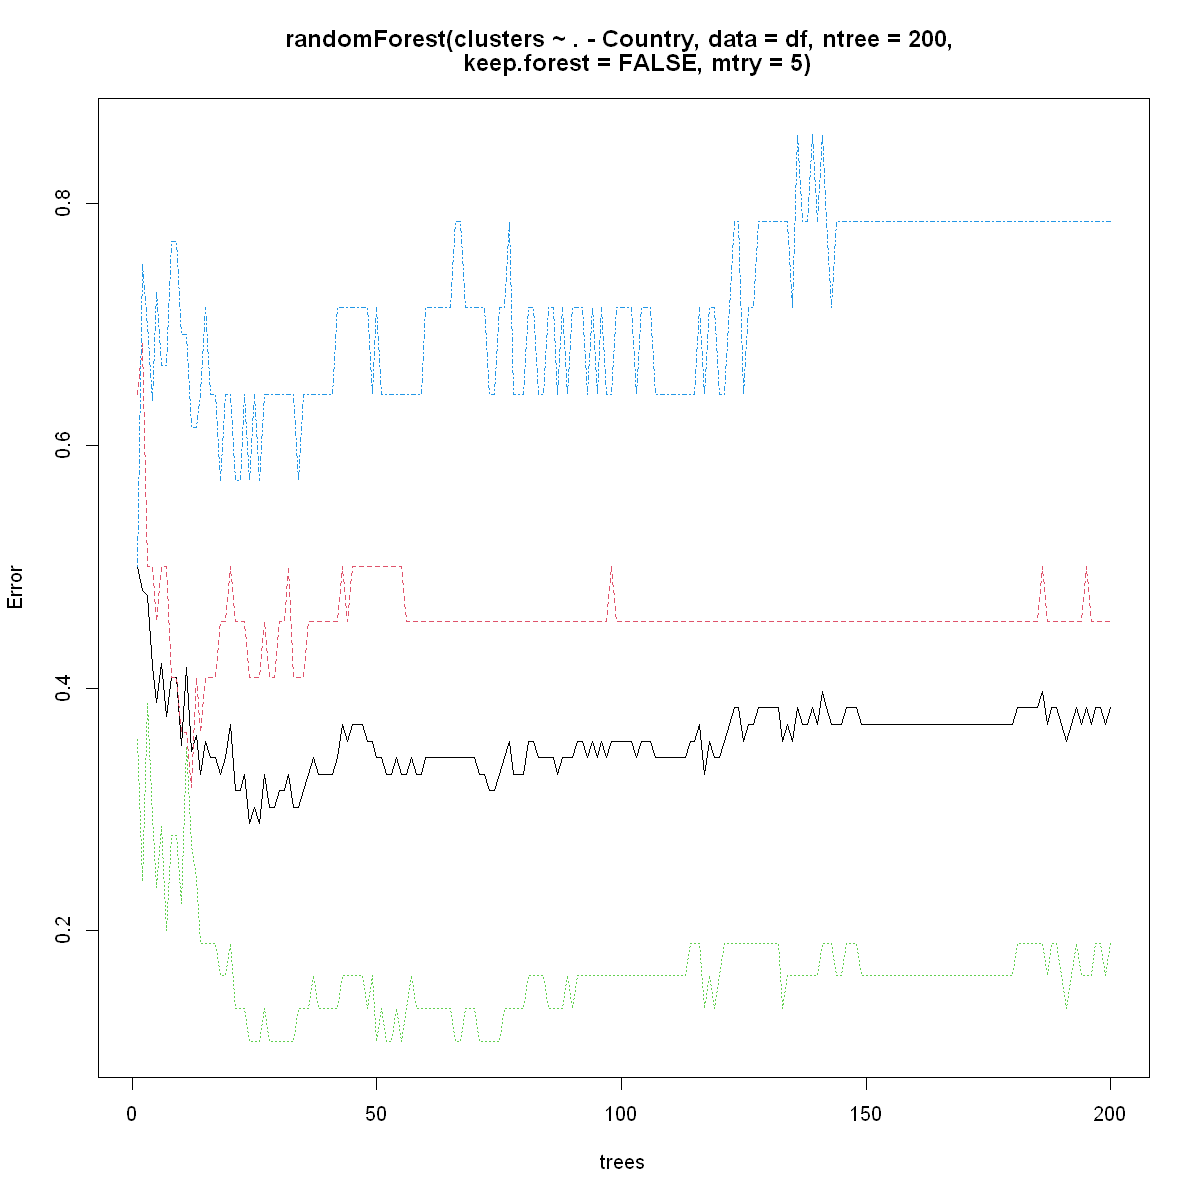

In [56]:
rf.water = randomForest(clusters~. -Country, data = df , ntree= 200,mtry=12)
print(rf.water)

summary(rf.water)

#importance <- importance(rf.water, sort = TRUE)
#importance

# create an importance plot
varImpPlot(rf.water, sort=TRUE, n.var=min(30, nrow(rf.water$importance)),
           type=NULL, class=NULL, scale=TRUE )
#plot
plot(randomForest(clusters~. -Country, data = df ,ntree=200,  keep.forest=FALSE, mtry=5) )

The MeanDecreaseGini measures the Gini importance = how important the features are over all splits done in the tree/forest - whereas for each individual split the Gini importance indicates how much the Gini criterion = "unequality/heterogeneity" was reduced using this split.
mori, upop, pcar popd, mcyc important and contributed most to obtaining such splits, so they are considered more important.

# MULTINOMIAL LOGISTIC REGRESSION

In [57]:
head(df)
with(df, table( df[,8]),)


,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Decentralized,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Hybrid,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Decentralized,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Centralized,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Centralized,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Hybrid,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666



  Centralized Decentralized        Hybrid 
           22            37            14 

In [58]:
head(df)

# Fit the model
model <- nnet::multinom(clusters ~. -Country  , data = df)
# Summarize the model
summary(model)

#z values
z <- summary(model)$coefficients/summary(model)$standard.errors
z
# 2-tailed z test
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

## extract the coefficients from the model and exponentiate
exp(coef(model))

# Make predictions
predicted.classes <- model %>% predict(df)
head(predicted.classes)

head(pp <- fitted(model))
# Model accuracy
mean(predicted.classes == df$clusters)

fit.MLR <- vglm( clusters ~ bicy + cart + mcyc +
                pcar+boat+wigc+cgdp+tpop+upop+popd+land+rifr+prec ,
                family=multinomial, df)
summary(fit.MLR)




,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Decentralized,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Hybrid,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Decentralized,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Centralized,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Centralized,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Hybrid,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# weights:  45 (28 variable)
initial  value 80.198697 
iter  10 value 59.664520
iter  20 value 49.402975
iter  30 value 25.170058
iter  40 value 13.899553
iter  50 value 11.327334
iter  60 value 10.564441
iter  70 value 10.417799
iter  70 value 10.417799
iter  80 value 10.394306
iter  80 value 10.394306
iter  90 value 10.389660
iter 100 value 10.173863
final  value 10.173863 
stopped after 100 iterations


Call:
nnet::multinom(formula = clusters ~ . - Country, data = df)

Coefficients:
              (Intercept)      bicy        cart       mcyc       pcar
Decentralized    5.282027 0.0152395  0.04464821 -0.1664503 -0.4338443
Hybrid         -49.420203 0.7808919 -1.33509260  0.2632466  0.9417403
                    boat     wigc          cgdp         tpop        upop
Decentralized  -5.336032 22.30988 -8.724022e-11 1.819983e-07 -0.04359247
Hybrid        -17.945908 35.65678  6.776504e-11 4.098167e-07 -0.07276879
                       popd          land          rifr        prec
Decentralized -0.0008738175  2.447105e-06 -7.849024e-05 0.002016690
Hybrid         0.0608591582 -1.039837e-04  7.503505e-04 0.003903273

Std. Errors:
               (Intercept)         bicy         cart         mcyc         pcar
Decentralized 4.894837e-23 4.039719e-22 2.799064e-22 5.003815e-22 5.541872e-22
Hybrid        8.167124e-23 1.302814e-21 1.740876e-22 1.439880e-21 1.540984e-21
                      boat         

,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Decentralized,1.079102e+23,3.772417e+19,1.595112e+20,-3.326469e+20,-7.828479e+20,-2.983955e+23,3.115175e+24,-13.079725,66987207,-1.673181e+19,-2.031256e+17,4.836449e+10,-2.663126e+14,7.920076e+16
Hybrid,-6.051114e+23,5.993886e+20,-7.669085e+21,1.828254e+20,6.111294e+20,-8.754197e+23,1.996149e+24,3.717669,56296024,-1.716296e+19,4.299945e+18,-2.786791e+12,2.898474e+15,4.673013e+16


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Decentralized,0,0,0,0,0,0,0,0.0000000000,0,0,0,0,0,0
Hybrid,0,0,0,0,0,0,0,0.0002010692,0,0,0,0,0,0


,(Intercept),bicy,cart,mcyc,pcar,boat,wigc,cgdp,tpop,upop,popd,land,rifr,prec
Decentralized,1.967684e+02,1.015356,1.0456599,0.8466649,0.6480132,4.814938e-03,4.887179e+09,1,1,0.9573440,0.9991266,1.000002,0.9999215,1.002019
Hybrid,3.444121e-22,2.183419,0.2631338,1.3011476,2.5644405,1.607649e-08,3.058746e+15,1,1,0.9298158,1.0627492,0.999896,1.0007506,1.003911


[1] Decentralized Hybrid        Decentralized Centralized   Centralized  
[6] Hybrid       
Levels: Centralized Decentralized Hybrid

,Centralized,Decentralized,Hybrid
1,3.202061e-02,9.679794e-01,4.005899e-27
2,7.882533e-05,3.893909e-11,9.999212e-01
3,2.967540e-01,7.032460e-01,8.227033e-60
4,9.657199e-01,1.535668e-06,3.427860e-02
5,9.996013e-01,3.987043e-04,3.311150e-12
6,1.004969e-60,2.591130e-52,1.000000e+00


[1] 0.9452055

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
"2 diagonal elements of the working w

Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta 

Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):


Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):
"fitted probabilities numerically 0 or 1 occurred"
Warning message in tfun(mu = mu, y = y, w = w, res = FALSE, eta = eta, extra = extra):
"fitted values close to 0 or 1"
Warning message in slot(family, "linkinv")(eta, extra = extra):



Call:
vglm(formula = clusters ~ bicy + cart + mcyc + pcar + boat + 
    wigc + cgdp + tpop + upop + popd + land + rifr + prec, family = multinomial, 
    data = df)

Coefficients: 
                Estimate Std. Error z value Pr(>|z|)   
(Intercept):1  8.524e+00  4.954e+00   1.720  0.08534 . 
(Intercept):2  1.064e+01  5.185e+00      NA       NA   
bicy:1        -1.145e-01  8.862e-02  -1.292  0.19650   
bicy:2        -1.191e-01  8.961e-02  -1.329  0.18388   
cart:1         2.589e-01  2.009e-01   1.289  0.19751   
cart:2         2.640e-01  2.044e-01   1.292  0.19644   
mcyc:1        -8.432e-02  6.420e-02  -1.313  0.18906   
mcyc:2        -9.462e-02  5.719e-02  -1.655  0.09802 . 
pcar:1        -1.372e-01  7.788e-02  -1.761  0.07819 . 
pcar:2        -3.633e-01  1.184e-01  -3.068  0.00215 **
boat:1         2.559e+00  1.561e+00      NA       NA   
boat:2         8.014e-01  1.818e+00   0.441  0.65930   
wigc:1        -1.096e+01  7.047e+00  -1.556  0.11977   
wigc:2        -2.378e+00  6.290e+0